# Pressure Sensor Dataset
Plot all the measurements and sort out the ones not useful

## Set up the environment

In [1]:
import pybis
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.figure import Figure

### Use Renkulab secrets

The following two cells are used when working with renkulab secrets.
This is a nice feature, where we don't need to show our personal access token, that could be misused.
Follow the steps described in the documentation to create a secret:
https://docs.renkulab.io/en/0.56.1/topic-guides/secrets/secrets.html

Save the secret with the name User-PAT_openBIS.txt for the following function.

In [2]:
def get_token() -> str:
    """
    This function gets the OpenBIS API key
    which is provided by Renkulab through the "Secrets" as
    a file stored in `/secrets/User-PAT_openBIS.txt`
    """
    with open("/secrets/User-PAT_openBIS.txt") as token_provider:
        token = token_provider.read().strip()
        return token

# don't print the following code: get_token(), unless you need to check how your PAT looks.
# delete the cell output afterwards again
# If you publish this either on github/ gitlab or openBIS others are able to see it and use it to login with youre account

In [3]:
# add domain name, change the following to your own domain instance
server = "openbis-empa-training.ethz.ch"
ob_connection = pybis.Openbis(f"https://{server}")

# Create Personal Access Token (PAT): Found in Admin UI > Tools > Access > Personal Access Token
    # see more information here: https://openbis.readthedocs.io/en/20.10.12-plus/software-developer-documentation/apis/personal-access-tokens.html#what-are-personal-access-tokens
    # Or Use Session Token: https://openbis.readthedocs.io/en/20.10.12-plus/user-documentation/general-users/additional-functionalities.html#session-token
# Owner of Token will be the Registrator in openBIS

# PAT is confidential: this can be handeld with secrets (makes sense for PAT, not so much for session token, as they are short living)
ob_connection.set_token(get_token())

#if the output of the cell is something of <pybis.pybis.Openbis object at xxxxxxxxx> then the connection works 
print(ob_connection)

### Without Renkulab secret

This is the fast forward use to access openBIS via API. But it is dangerous, as everyone who uses your session token or PAT; as long as they are valid, is able to login to openBIS and pretend to be you.

In [23]:
# add the domain name in the following form to access it via PyBIS
# to access openBIS from Renku, the connection needs to be requested via ticketing system. Write to: openBIS-support@empa.ch
server = "openbis-empa-training.ethz.ch"
ob_connection = pybis.Openbis(f"https://{server}")

# Use Personal Access Token (PAT): Found in Admin UI > Tools > Access > Personal Access Token
    # see more information here: https://openbis.readthedocs.io/en/20.10.12-plus/software-developer-documentation/apis/personal-access-tokens.html#what-are-personal-access-tokens
# Or Use Session Token: https://openbis.readthedocs.io/en/20.10.12-plus/user-documentation/general-users/additional-functionalities.html#session-token
# Owner of Token will be the Registrator in openBIS

# PAT or session token is confidential: this can be handeld with secrets
ob_connection.set_token("obtraining20-251028082245495x101615EBCB36A8C60CCC06314E508FD5")

# if the output of the cell is something of <pybis.pybis.Openbis object at xxxxxxxxx> then the connection works 
print(ob_connection)

In [24]:
os.getcwd()

'/home/renku/work/openbis-renku-mirror'

## Download datasets
Downloading the datasets can take some time. if it is successful you will see a folder in your directory on the left side called "datasets".
To access those datasets, you need to know in what default experiment/collection they are located:
- Go to the collection where you store youre data
- open [Edit]
- open [More] and Show Idendification info
  
There you get the identifier you will need to add to access your data in openBIS

In [25]:
# get collection/ default experiment identifier where data is located
coll = ob_connection.get_collection("/OBTRAINING20/PROJECT_FOR_EXPERIMENT/PROJECT_FOR_EXPERIMENT_EXP_4")
# get objects within the collection
collection_objects = coll.get_objects()

# choose the type of dataset you used in openBIS. Following the workshop, you have used "Raw Data" and the type below is left.
datasets = ob_connection.get_datasets(collection=coll, type="RAW_DATA")

#Create datasets folder
ds_folder = "./datasets"
Path(ds_folder).mkdir(exist_ok=True)
#Donwload all datasets
for dataset in datasets:
    dataset.download(
        destination = ds_folder,        # download files to folder my_data/
        create_default_folders = False, # ignore the /original/DEFAULT folders made by openBIS
        wait_until_finished = False,    # download in background, continue immediately
        workers = 10                    # 10 downloads parallel (default)
    )

## Explore dataset
After we are done downloading datasets from OpenBIS, we can have a look at them locally.

Using `Pathlib.glob`, we can search for all files ending with ".csv" in `ds_folder`, which in our case is `./datasets`, the folder were we just downloaded all data.

In [27]:
file_list=[]
file_list = list(Path(ds_folder).glob("*.csv")) + list(Path(ds_folder).glob("*.xlsx"))
print(f"We found {len(file_list)} files matching csv and xlsx")

We found 18 files matching csv and xlsx


Now we can have a look at the file list:

In [28]:
file_list

[PosixPath('datasets/230307_FS_2-3.csv'),
 PosixPath('datasets/251028_FS_1-3.csv'),
 PosixPath('datasets/DMSO_FS_0923_133114.csv'),
 PosixPath('datasets/230530FS1-3.csv'),
 PosixPath('datasets/230223_FS_5-3.csv'),
 PosixPath('datasets/230315_FS_5-3.csv'),
 PosixPath('datasets/230207fs1-3_0208_153427.csv'),
 PosixPath('datasets/230330_FS2-3.csv'),
 PosixPath('datasets/230209_FS_2-3.csv'),
 PosixPath('datasets/230206_FS_5-3_0207_151545.csv'),
 PosixPath('datasets/pentanolfs_0922_160111.csv'),
 PosixPath('datasets/230530FS1-3(1).csv'),
 PosixPath('datasets/230314_FS_1-3.csv'),
 PosixPath('datasets/acetonfs_0924_150458.csv'),
 PosixPath('datasets/230605_FS2-3.csv'),
 PosixPath('datasets/230621_FS9-3.csv'),
 PosixPath('datasets/FS_EtOH_220920_132622.csv'),
 PosixPath('datasets/FS-Aceton_220921_124032.csv')]

And finally, we can load one example file using Pandas:

Because we know the header is 8 lines long, we set `skiprows=8`.

In [29]:
#example of one file
df = pd.read_csv(file_list[0], sep=',', skiprows=8)  # adjust skiprows if needed. Since the first 8 rows are metadata from measurement, we can skip them for the plots
df

,Reading,Unit,Range Digits,Disp Digits,Math,Start Group,Limit1 High,Limit1 Low,Limit2 High,Limit2 Low,Terminal,Questionable,Origin,Relative Time,Channel,CH Label
0,0.000751,Volt DC,0.1,6.5,F,F,F,F,F,F,Front,F,Main,0.000000,NaN,NaN
1,0.000784,Volt DC,0.1,6.5,F,F,F,F,F,F,Front,F,Main,0.240144,NaN,NaN
2,0.000780,Volt DC,0.1,6.5,F,F,F,F,F,F,Front,F,Main,0.480288,NaN,NaN
3,0.000754,Volt DC,0.1,6.5,F,F,F,F,F,F,Front,F,Main,0.720428,NaN,NaN
4,0.000748,Volt DC,0.1,6.5,F,F,F,F,F,F,Front,F,Main,0.962746,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338212,0.334903,Volt DC,1.0,6.5,F,F,F,F,F,F,Front,F,Main,81220.836207,NaN,NaN
338213,0.334916,Volt DC,1.0,6.5,F,F,F,F,F,F,Front,F,Main,81221.076332,NaN,NaN
338214,0.334910,Volt DC,1.0,6.5,F,F,F,F,F,F,Front,F,Main,81221.316462,NaN,NaN
338215,0.334911,Volt DC,1.0,6.5,F,F,F,F,F,F,Front,F,Main,81221.556591,NaN,NaN


Now we can prepare a plot of "Reading" against "Time".
To make it cleaner, we will prepare a plotting function:

251028_FS_1-3.csv
DMSO_FS_0923_133114.csv
230530FS1-3.csv
230223_FS_5-3.csv
230315_FS_5-3.csv
230207fs1-3_0208_153427.csv
230330_FS2-3.csv
230209_FS_2-3.csv
230206_FS_5-3_0207_151545.csv
pentanolfs_0922_160111.csv
230530FS1-3(1).csv
230314_FS_1-3.csv
acetonfs_0924_150458.csv
230605_FS2-3.csv
230621_FS9-3.csv
FS_EtOH_220920_132622.csv
FS-Aceton_220921_124032.csv


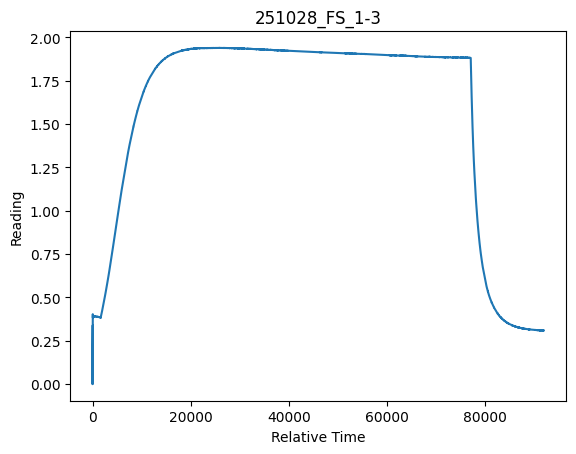

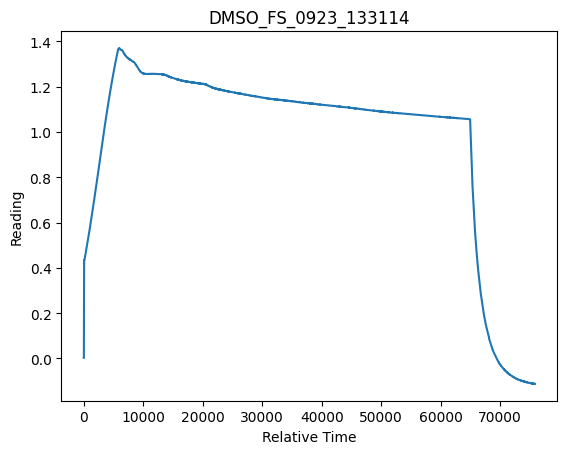

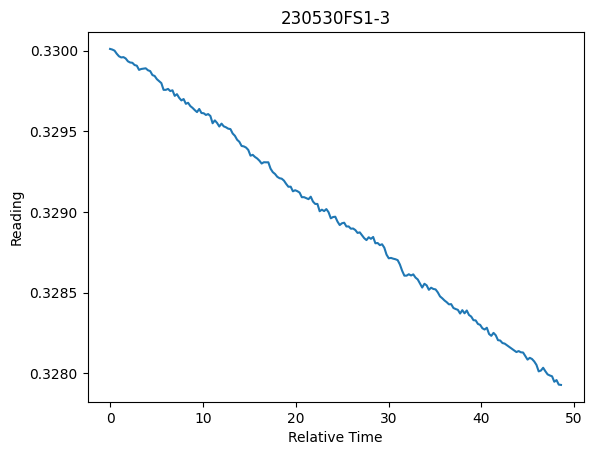

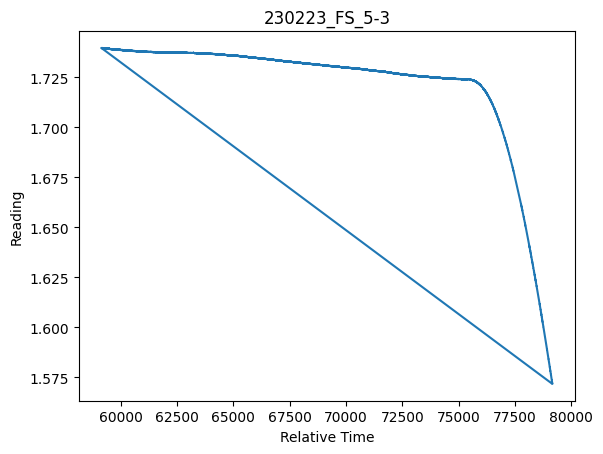

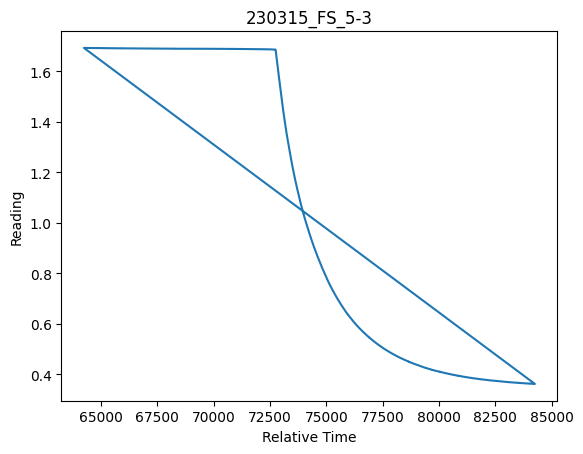

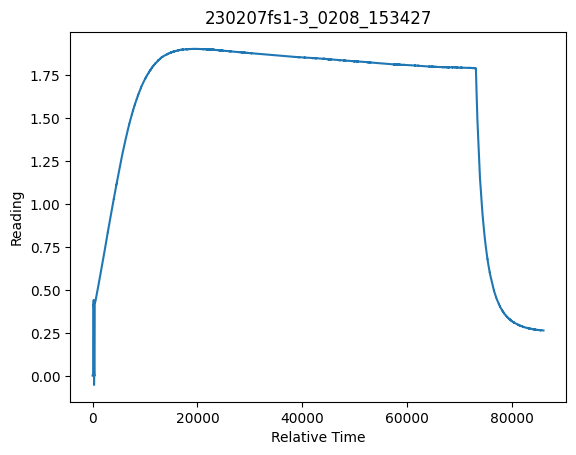

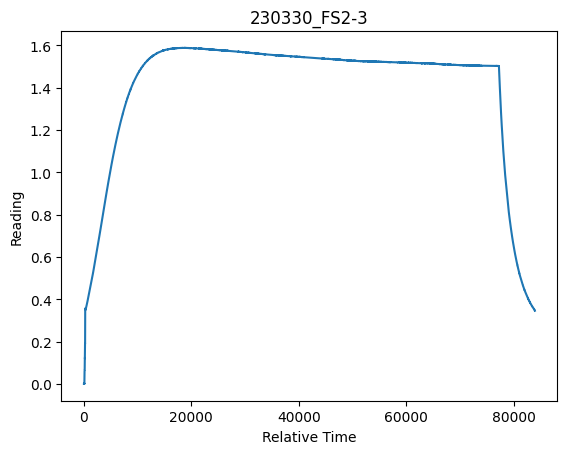

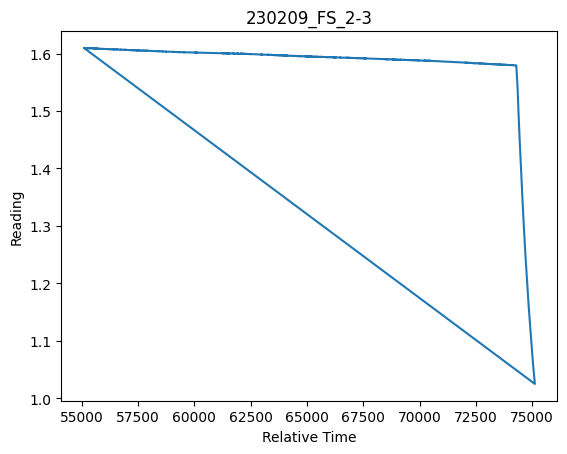

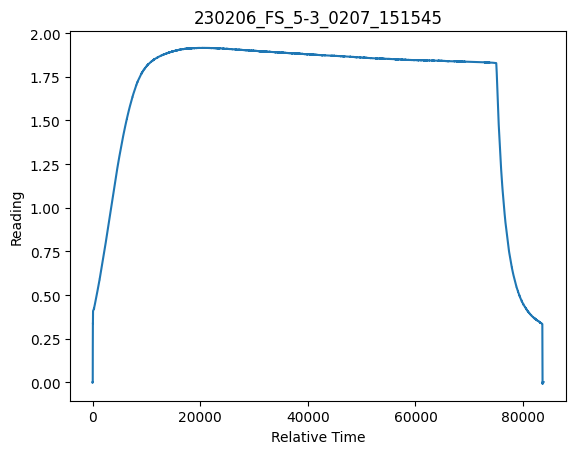

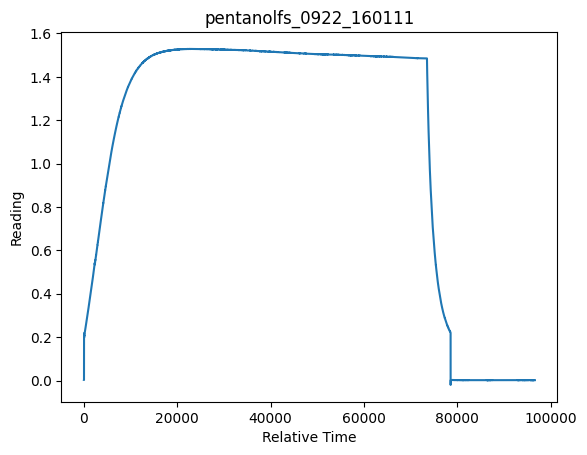

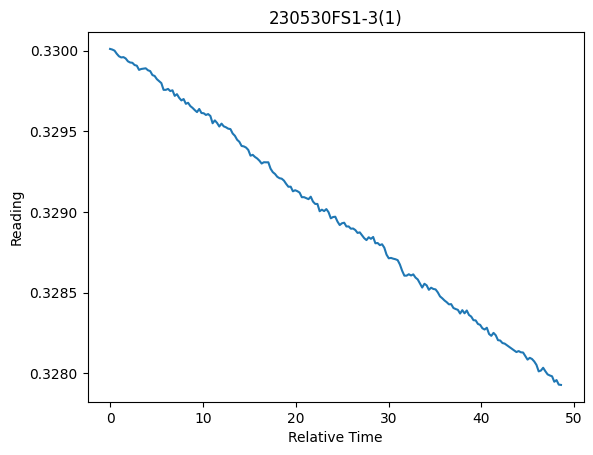

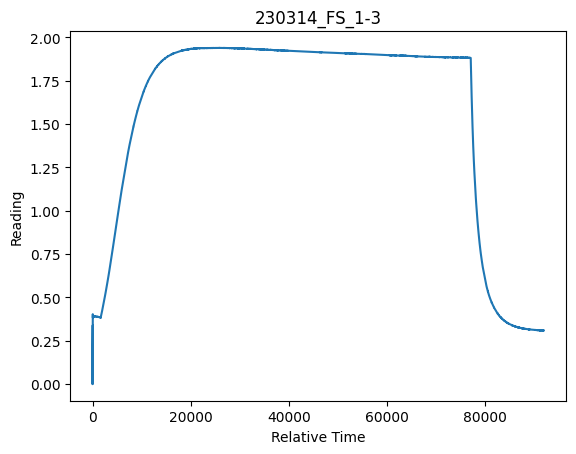

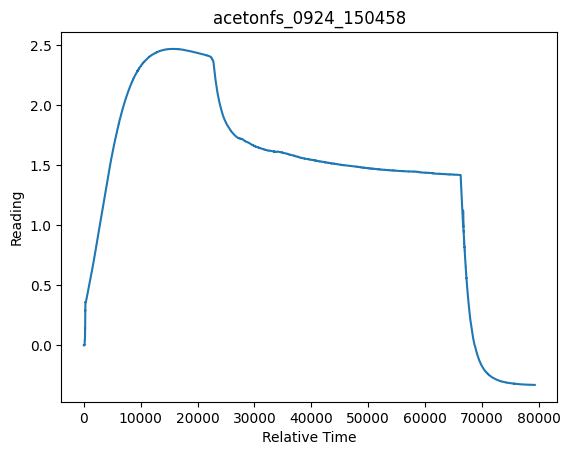

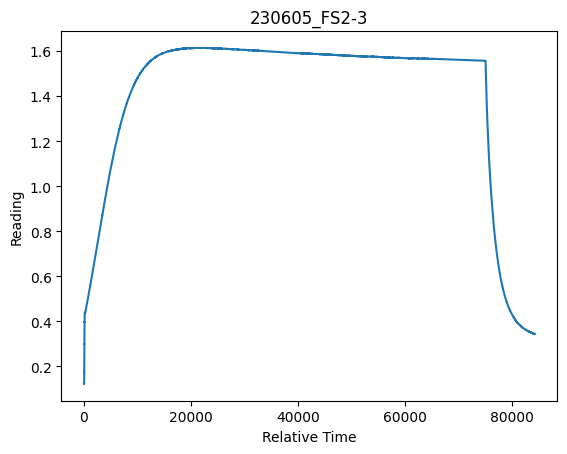

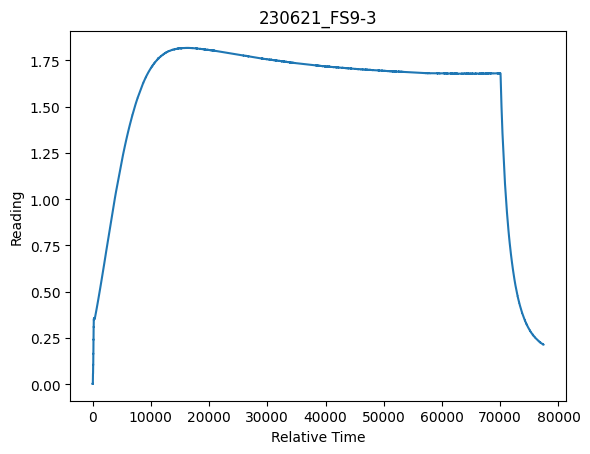

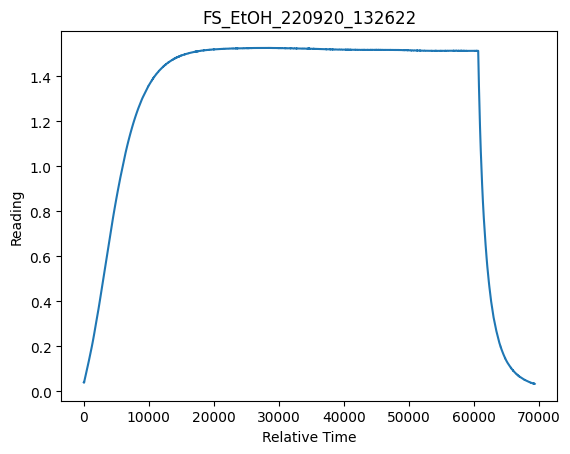

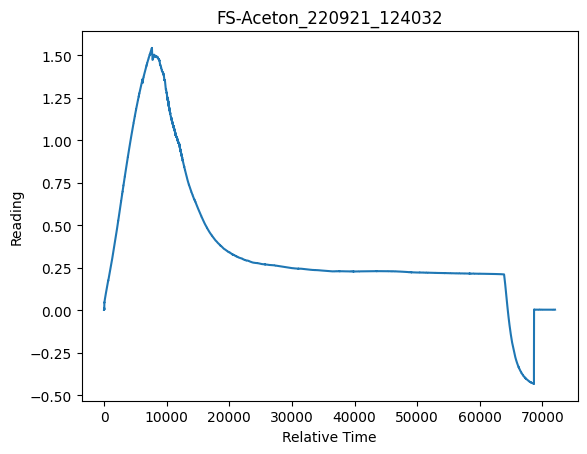

In [30]:
def prepare_plot(df: pd.DataFrame, experiment_name: str) -> Figure:
    fig, ax = plt.subplots()
    ax.plot(df["Relative Time"], df["Reading"])
    ax.set_title(experiment_name)
    ax.set_xlabel("Relative Time")
    ax.set_ylabel("Reading")
    return fig


plots = dict()
for filepath in file_list[1:]:
    #try:
    # Read CSV or XLSX
    match filepath.suffix:
        case ".csv":
            df = pd.read_csv(filepath, sep=',', skiprows=8)  # adjust skiprows if needed
        case ".xlsx":
            df = pd.read_excel(filepath)
        case _:
            continue
    #dfs.append(df) #this gives an error? @ simone. Funktioniert auch ohne
    print(filepath.name)
    new_fig = prepare_plot(df, str(filepath.stem))
    plots[filepath.stem] = new_fig
    

## Cleaning the plots
Going through the list of names and the single plots, we can divide them into two groups:

Successful experiments:
- 230621_FS9-3.csv
- 230314_FS_1-3.csv
- 230206_FS_5-3_0207_151545.csv
- pentanolfs_0922_160111.csv
- 230605_FS2-3.csv
- 230330_FS2-3.csv
- 230207fs1-3_0208_153427.csv
- FS_EtOH_220920_132622.csv
- 230605_FS2-3.csv
- 230307_FS_2-3.csv
  
unsuccessful experiments:
- DMSO_FS_0923_133114.csv
- FS-Aceton_220921_124032.csv
- 230315_FS_5-3.csv
- 230223_FS_5-3.csv
- 230209_FS_2-3.csv
- acetonfs_0924_150458.csv
- 230530FS1-3.csv

In [31]:
plots

{'251028_FS_1-3': <Figure size 640x480 with 1 Axes>,
 'DMSO_FS_0923_133114': <Figure size 640x480 with 1 Axes>,
 '230530FS1-3': <Figure size 640x480 with 1 Axes>,
 '230223_FS_5-3': <Figure size 640x480 with 1 Axes>,
 '230315_FS_5-3': <Figure size 640x480 with 1 Axes>,
 '230207fs1-3_0208_153427': <Figure size 640x480 with 1 Axes>,
 '230330_FS2-3': <Figure size 640x480 with 1 Axes>,
 '230209_FS_2-3': <Figure size 640x480 with 1 Axes>,
 '230206_FS_5-3_0207_151545': <Figure size 640x480 with 1 Axes>,
 'pentanolfs_0922_160111': <Figure size 640x480 with 1 Axes>,
 '230530FS1-3(1)': <Figure size 640x480 with 1 Axes>,
 '230314_FS_1-3': <Figure size 640x480 with 1 Axes>,
 'acetonfs_0924_150458': <Figure size 640x480 with 1 Axes>,
 '230605_FS2-3': <Figure size 640x480 with 1 Axes>,
 '230621_FS9-3': <Figure size 640x480 with 1 Axes>,
 'FS_EtOH_220920_132622': <Figure size 640x480 with 1 Axes>,
 'FS-Aceton_220921_124032': <Figure size 640x480 with 1 Axes>}

In [32]:
#read text files, clean the names
with open("successful.txt") as f:
    successful_filenames = [line.strip() for line in f]  # removes whitespace and newlines
with open("unsuccessful.txt") as f:
    unsuccessful_filenames = [line.strip() for line in f]

successful_list = [f for f in file_list if os.path.basename(f) in successful_filenames]
unsuccessful_list  = [f for f in file_list if os.path.basename(f) in unsuccessful_filenames]

In [33]:
#define the plot: could be done in a funciton

def plot_group(file_list, title):
    fig = plt.figure(figsize=(8,4))  # One figure for the whole group
    for filepath in file_list:

        # Read CSV or Excel
        if filepath.suffix == ".csv":
            df = pd.read_csv(filepath, sep=',', skiprows=8)  # adjust skiprows if needed
        else:
            df = pd.read_excel(filepath)

        # Plot line with filename as label
        label = os.path.basename(filepath)
        plt.plot(df["Relative Time"], df["Reading"], label=label, alpha=0.8)


    plt.title(title)
    plt.xlabel("Relative Time")
    plt.ylabel("Reading")
    plt.legend(loc='lower center')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return fig

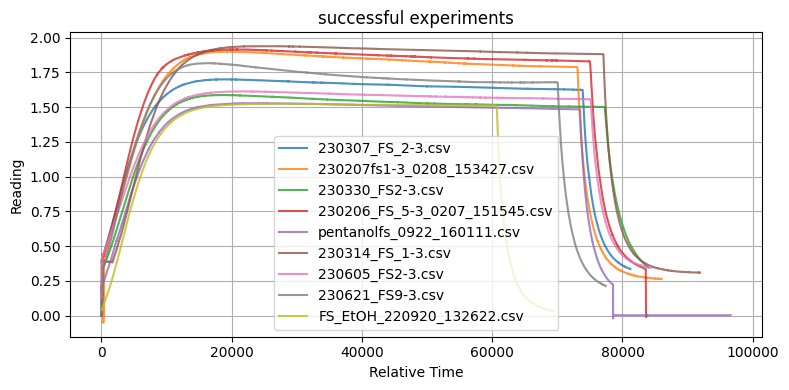

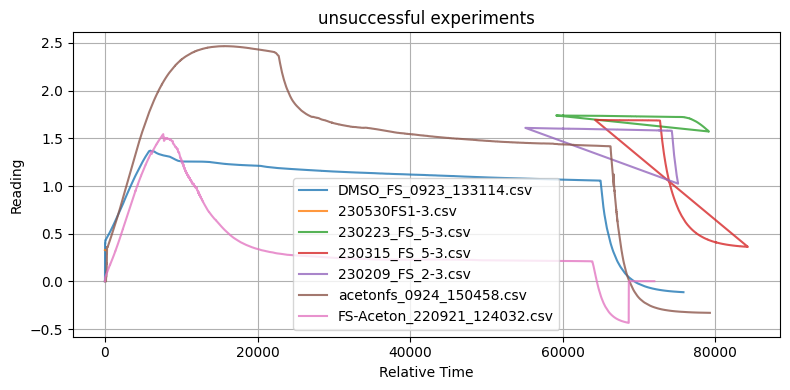

In [35]:
# Combined plot for successful files
successful_fig = plot_group(successful_list, "successful experiments")

# Combined plot for unsuccessful files
unsuccessful_fig = plot_group(unsuccessful_list, "unsuccessful experiments")

### Load Dataset from another repository for reference

If you have an already published data set, e.g. from Zenodo you would like to compare, below is an example how this would look.

In [ ]:
#adjust the name to the repository added:

filepath_zenodo="../tryoutexport-doi-10.5281-zenodo.17342141/230314_FS_1-3.csv"
#find the file
df_zenodo = pd.read_csv(filepath_zenodo, sep=',', skiprows=8)  # adjust skiprows if needed. Since the first 8 rows are metadata from measurement, we can skip them for the plots
df_zenodo

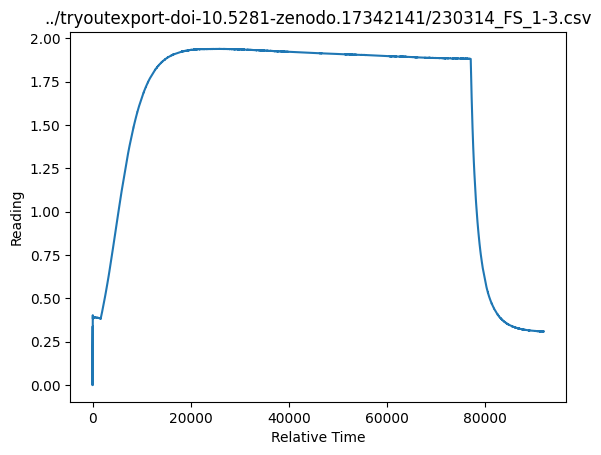

In [16]:
# a simple plot to demonstrate that data can easily be accessed from zenodo
df = pd.read_csv(filepath_zenodo, sep=',', skiprows=8)  # adjust skiprows if needed
new_fig = prepare_plot(df, str(filepath_zenodo))

## Save plots
Now we want to save the results `successful_fig` and `unsuccessful_fig`in openBIS as a result.
To do so, we first save them as png.

In [17]:
# save the plots with savefig to datasets location
# datasets are excluded from saving to git (.gitignore)

successful_fig.savefig('./datasets/sucessfull.png')
unsuccessful_fig.savefig('./datasets/unsuccessful.png')

In [20]:
#Load saved png files to openBIS
dest_object = ob_connection.get_object("/GROUPA_STEFFI/RENKU_USE_CASE/FOLDER4") #identifier to destination in openBIS

# define the name of the file, type of attachement and props.
# ELN Preview gives a Preview in openBIS for the first plot
# other types of datasets are defined in your openBIS instance 
ds_new = ob_connection.new_dataset(sample=dest_object, files=["./datasets/sucessfull.png", "./datasets/unsuccessful.png"], type="ELN_PREVIEW",
                                  props={'$name': "Data Plot", 'notes': "plot from all measurements"}) #to give the folder a name as well
ds_new.save()

DataSet successfully created.


attribute,value
code,20251027135642489-3770
permId,20251027135642489-3770
type,ELN_PREVIEW
kind,PHYSICAL
experiment,/GROUPA_STEFFI/RENKU_USE_CASE/RENKU_USE_CASE_EXP_4
sample,/GROUPA_STEFFI/RENKU_USE_CASE/FOLDER4
parents,[]
children,[]
components,[]
containers,[]


### Save notebook and HTML to the same directory in openBIS

In [21]:
#get name of this current notebook - only works if there is just one juypter in this directory
Notebookname=glob.glob("*.ipynb")[0]
Notebookname

'openBIS-Connection.ipynb'

In [22]:
# The following lines will save a html of this jupyter notebook to the session here

from nbconvert import HTMLExporter
import codecs
import nbformat

exporter = HTMLExporter()
output_notebook = nbformat.read(Notebookname, as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(Notebookname + '.html', 'w', encoding='utf-8').write(output)

In [23]:
#save HTML as analyzed notebook to openBIS
dest_object = ob_connection.get_object("/GROUPA_STEFFI/RENKU_USE_CASE/FOLDER4") #identifier to destination in openBIS

ds_new = ob_connection.new_dataset(sample=dest_object, files=[Notebookname, Notebookname +'.html'], type="ANALYSIS_NOTEBOOK",
                                  props={'$name': "Data Plot Notebook", 'notes': "Notebook to plot all measurements"}) #to give the folder a name as well
ds_new.save()

DataSet successfully created.


attribute,value
code,20251027135647385-3771
permId,20251027135647385-3771
type,ANALYSIS_NOTEBOOK
kind,PHYSICAL
experiment,/GROUPA_STEFFI/RENKU_USE_CASE/RENKU_USE_CASE_EXP_4
sample,/GROUPA_STEFFI/RENKU_USE_CASE/FOLDER4
parents,[]
children,[]
components,[]
containers,[]
